### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
### Data Collection
import pandas_datareader as pdr
import pandas as pd
import numpy as np
df=pd.read_csv('Key.csv')
key=Key['key'][0]

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')

In [4]:
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-02-16 00:00:00+00:00,96.64,96.8500,94.610,95.02,49057916,22.467518,22.516340,21.995570,22.090890,196231664,0.0,1.0
1,AAPL,2016-02-17 00:00:00+00:00,98.12,98.2100,96.150,96.67,44863243,22.811599,22.832522,22.353600,22.474493,179452972,0.0,1.0
2,AAPL,2016-02-18 00:00:00+00:00,96.26,98.8900,96.091,98.84,39020983,22.379173,22.990613,22.339883,22.978989,156083932,0.0,1.0
3,AAPL,2016-02-19 00:00:00+00:00,96.04,96.7599,95.800,96.00,35374173,22.328026,22.495393,22.272229,22.318727,141496692,0.0,1.0
4,AAPL,2016-02-22 00:00:00+00:00,96.88,96.9000,95.920,96.31,34280758,22.523315,22.527965,22.300128,22.390798,137123032,0.0,1.0


In [5]:
df1=df.reset_index()['close']
df1.head()

0    96.64
1    98.12
2    96.26
3    96.04
4    96.88
Name: close, dtype: float64

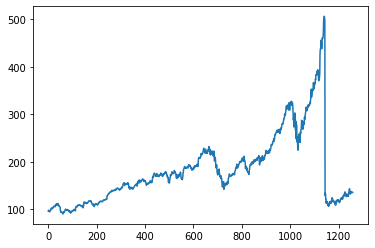

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
#Scaling the data for the LSTM
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1259, 1)

In [8]:
print(df1)

[[0.01515334]
 [0.01871317]
 [0.01423933]
 ...
 [0.10835839]
 [0.10773301]
 [0.10831028]]


In [9]:
#Splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [10]:
train_data.shape,test_data.shape

((818, 1), (441, 1))

In [11]:
#Convert an array of values into a dataset matrix
#Time steps will be taking as 100
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a) #This will be 100 dimension
		dataY.append(dataset[i + time_step, 0]) #This will be single dimension
	return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
X_train.shape,y_train.shape,X_test.shape,ytest.shape

((717, 100), (717,), (340, 100), (340,))

In [14]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_train.shape,X_test.shape

((717, 100, 1), (340, 100, 1))

In [15]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 116ms/step - loss: 0.0172 - val_loss: 0.0511
Epoch 2/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0031 - val_loss: 0.0245
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 0.0261
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 5.1840e-04 - val_loss: 0.0206
Epoch 5/100
12/12 [==============================] - 0s 24ms/step - loss: 4.9210e-04 - val_loss: 0.0200
Epoch 6/100
12/12 [==============================] - 0s 24ms/step - loss: 4.3039e-04 - val_loss: 0.0194
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 3.9803e-04 - val_loss: 0.0190
Epoch 8/100
12/12 [==============================] - 0s 19ms/step - loss: 3.2656e-04 - val_loss: 0.0187
Epoch 9/100
12/12 [==============================] - 0s 22ms/step - loss: 3.3541e-04 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 0s 24ms/step - loss:

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [19]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

163.82382052678858

In [22]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

250.8955556474143

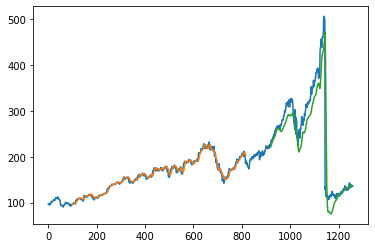

In [24]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [25]:
len(test_data)

441

In [26]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [28]:
temp_input=list(x_input)
print(temp_input)
print(len(temp_input))
temp_input=temp_input[0].tolist()

[array([0.05164161, 0.04036079, 0.04300661, 0.0527721 , 0.05921828,
       0.05712568, 0.06126278, 0.06361996, 0.05455201, 0.06292243,
       0.05488876, 0.05950692, 0.05924233, 0.06405292, 0.08192423,
       0.07398677, 0.07420325, 0.07304871, 0.06898376, 0.06167168,
       0.06535177, 0.06381239, 0.06111846, 0.0594107 , 0.05943476,
       0.06316296, 0.05017438, 0.06008419, 0.044546  , 0.04432952,
       0.04834636, 0.05919423, 0.06900782, 0.06819002, 0.06248948,
       0.06164762, 0.07011425, 0.06944077, 0.06956103, 0.07206254,
       0.06987372, 0.06660253, 0.06806975, 0.06494287, 0.05654841,
       0.05972339, 0.06179194, 0.06313891, 0.06905592, 0.07788334,
       0.07874925, 0.07841251, 0.07675286, 0.08036079, 0.08187613,
       0.07562237, 0.0791341 , 0.0771377 , 0.07562237, 0.09029465,
       0.09012628, 0.09226699, 0.08734817, 0.0911365 , 0.09991581,
       0.09770295, 0.10013229, 0.11148527, 0.10710764, 0.10434155,
       0.1018641 , 0.09397474, 0.09782321, 0.08721587, 0.0976

In [31]:
temp_input[0],len(temp_input)

(0.05164161154539987, 100)

In [32]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.11174]
101
1 day input [0.04036079 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278
 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233
 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376
 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476
 0.06316296 0.05017438 0.06008419 0.044546   0.04432952 0.04834636
 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762 0.07011425
 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253 0.06806975
 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891 0.06905592
 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079 0.08187613
 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465 0.09012628
 0.09226699 0.08734817 0.0911365  0.09991581 0.09770295 0.10013229
 0.11148527 0.10710764 0.10434155 0.1018641  0.09397474 0.09782321
 0.08721587 0.09760673 0.10032471 0.09294047 0.09250752 0.09753458
 0.0927721  0.08851473 0.09017438 0.10027661 0.11191822 0.11720986
 0.12647023 0.1270475  0.12440168 0.

In [33]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [34]:
len(df1)

1259

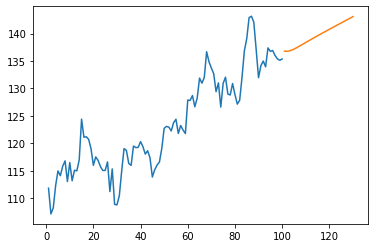

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

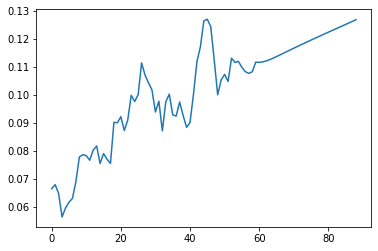

In [37]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

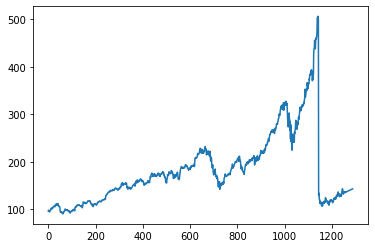

In [39]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)